In [1]:
using Pipe
using MarketTechnicals
using Plots
# using TimeSeries
using DataFrames
using StatsPlots
using CSV
using RollingFunctions
using Query
using GLMakie

┌ Info: Precompiling MarketTechnicals [4f8c86c6-9e40-5506-9807-98571cb48bc8]
└ @ Base loading.jl:1317
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1317
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1317
┌ Info: Precompiling RollingFunctions [b0e4dd01-7b14-53d8-9b45-175a3e362653]
└ @ Base loading.jl:1317
┌ Info: Precompiling Query [1a8c2f83-1ff3-5112-b086-8aa67b057ba1]
└ @ Base loading.jl:1317
┌ Info: Precompiling GLMakie [e9467ef8-e4e7-5192-8a1a-b1aee30e663a]
└ @ Base loading.jl:1317


In [3]:

# ta = readtimearray("../data/csv/BTCUSDT-15m.csv", format="yyyy-mm-dd HH:MM", delim=',', meta=nothing)
# taf = @pipe ta |> from(_, DateTime(2021, 3, 1)) |> to(_, DateTime(2021, 4, 1)) 
# df = DataFrame(taf)


LoadError: UndefVarError: df not defined

In [5]:
start_date = DateTime(2021, 5, 1)
end_date = DateTime(2021, 5, 2)

period_ema_slow = 200
period_ema_mid = 100
period_ema_fast = 50
period_ema_scalp = 21

fast_low_n = 14
fast_high_n = 14
mid_low_n = 26
mid_high_n = 26


26

In [6]:
# csv_df = DataFrame(CSV.File("../data/csv/BTCUSDT-15m.csv", dateformat="yyyy-mm-dd HH:MM"))
# df = csv_df[(csv_df.time .>= start_date) .& (csv_df.time .<= end_date) , :]

csv_df = df
df = csv_df[(csv_df.time .>= start_date) .& (csv_df.time .<= end_date) , :]

ndfrows = nrow(df)



LoadError: UndefVarError: df not defined

In [758]:
# prepare() = begin
    df = csv_df[(csv_df.time .>= start_date) .& (csv_df.time .<= end_date) , :]
    ndfrows = nrow(df)
    insertcols!(df, 
        :ema_slow => zeros(ndfrows), 
        :ema_mid =>  zeros(ndfrows), 
        :ema_fast =>  zeros(ndfrows), 
        :ema_scalp =>  zeros(ndfrows)
    )

    insertcols!(df, 
        :log_ema_mid_slow =>  zeros(ndfrows), 
        :log_ema_fast_slow =>  zeros(ndfrows), 
        :log_ema_fast_mid =>  zeros(ndfrows),
    #     :log_ema_scalp_slow =>  zeros(ndfrows), 
    #     :log_ema_scalp_fast =>  zeros(ndfrows), 
    #     :log_close_ema_scalp =>  zeros(ndfrows), 
        :log_close_ema_fast =>  zeros(ndfrows), 
        :log_close_ema_mid =>  zeros(ndfrows), 
        :log_close_ema_slow =>  zeros(ndfrows),    
    )
    insertcols!(df, 
        :roll_fast_low => zeros(ndfrows),
        :roll_fast_high => zeros(ndfrows),
        :roll_mid_low => zeros(ndfrows),
        :roll_mid_high => zeros(ndfrows),
        
        :log_close_roll_mid_high =>  zeros(ndfrows), 
        :log_close_roll_mid_low =>  zeros(ndfrows), 
    )
    insertcols!(df, 
        :reason => [fill("", (ndfrows,1))...],
        :price_in_long => [fill(0., (ndfrows,1))...],
        :price_out_long => [fill(0., (ndfrows,1))...],
        :stoploss_long => [fill(0., (ndfrows,1))...],
        :buy_long => [fill(0., (ndfrows,1))...],
        :sell_long => [fill(0., (ndfrows,1))...],
        :pnl => [fill(0., (ndfrows,1))...],
        :capital => [fill(0., (ndfrows,1))...]
    )
    insertcols!(df, :unix_time => datetime2unix.(df.time))
    df
# end
1

1

In [759]:
# fill_indicators(df) = begin
    df.ema_slow .= vec([fill(df.close[1], (period_ema_slow - 1,1)); ema(df.close, period_ema_slow) ])
    df.ema_mid .= vec([fill(df.close[1], (period_ema_mid - 1,1)); ema(df.close, period_ema_mid) ])
    df.ema_fast .= vec([fill(df.close[1], (period_ema_fast - 1,1)); ema(df.close, period_ema_fast) ])
    df.ema_scalp .= vec([fill(df.close[1], (period_ema_scalp - 1,1)); ema(df.close, period_ema_scalp) ])
    df.log_ema_mid_slow .= log.( df.ema_mid ./ df.ema_slow ) .* 1000
    df.log_ema_fast_slow .= log.( df.ema_fast ./ df.ema_slow ) .* 1000
    df.log_ema_fast_mid .= log.( df.ema_fast ./ df.ema_mid ) .* 1000
    # df.log_ema_scalp_slow .= log.( df.ema_scalp ./ df.ema_slow ) .* 1000
    # df.log_ema_scalp_fast .= log.( df.ema_scalp ./ df.ema_fast ) .* 1000
    # df.log_close_ema_scalp .= log.( df.close ./ df.ema_scalp ) .* 1000
    df.log_close_ema_fast .= log.( df.close ./ df.ema_fast ) .* 1000
    df.log_close_ema_mid .= log.( df.close ./ df.ema_slow ) .* 1000 
    df.log_close_ema_slow .= log.( df.close ./ df.ema_slow ) .* 1000
    
    df.roll_fast_low = runmin(df.low, fast_low_n)
    df.roll_fast_high = runmax(df.low, fast_high_n)
    df.roll_mid_low = runmin(df.low, mid_low_n)
    df.roll_mid_high = runmax(df.low, mid_high_n)
    
    
    df.log_close_roll_mid_low .= log.( df.close ./ df.roll_mid_low ) .* 1000
    df.log_close_roll_mid_high .= log.( df.close ./ df.roll_mid_high ) .* 1000
    
# end
1

1

In [760]:

    df = df[300:ndfrows,:]
    ndfrows = nrow(df)

12527

In [761]:
# cleanup_trades(df) = begin
    ndfrows = nrow(df)
    df.reason .= [fill("", (ndfrows,1))...]
    df.price_in_long .= [fill(0., (ndfrows,1))...]
    df.price_out_long .= [fill(0., (ndfrows,1))...]
    df.stoploss_long .= [fill(0., (ndfrows,1))...]
    df.buy_long .= [fill(0., (ndfrows,1))...]
    df.sell_long .= [fill(0., (ndfrows,1))...]
    df.pnl .= [fill(0., (ndfrows,1))...]
    df.capital .= [fill(0., (ndfrows,1))...]
# end
1

1

In [762]:
# backtest(df) = begin
    capital, risk_percent = 100., 0.01
    isLong, price_in_long, price_out_long, buy_long, pnl, stop_long_price  = false, 0, 0, 0, 0, 0 
    time_gone_long = 0
    fee_percent = 0.001
    for r in eachrow(df)
        if isLong
            nperiods = Dates.value(Minute(r.time - time_gone_long))/15
            percent_gain = (r.close - price_in_long) / price_in_long * 100
            do_sell = (r.log_close_ema_fast > 50 ) ||
                (nperiods > 21 && r.log_ema_fast_slow < 2 && r.close > r.ema_fast) ||
                (nperiods < 6 && percent_gain < -2) ||
                percent_gain >= 7
        
            if r.close < stop_long_price || do_sell # close SL            
                price_out_long = r.close * (1 - fee_percent)
                pnl = buy_long * (price_out_long - price_in_long)
                capital += pnl
                isLong = false
                r.pnl = pnl
                r.reason = "STOP LONG"
                r.sell_long = buy_long
                r.price_out_long = price_out_long
#                 stop_reason = "SL"
#             elseif (r.close - price_in_long) / price_in_long * 100 >= 7
#                 capital += pnl
#                 isLong = false
#                 r.pnl = pnl
#                 r.reason = "TP"
#                 r.sell_long = buy_long
#                 r.price_out_long = price_out_long
# #                 println("reason: ", r.reason)
# #                 println("sell_long: ", r.sell_long)
# #                 println("price_out_long: ", r.price_out_long)
# #                 println("pnl: ", r.pnl)

            end
        else #not in pos
            if r.log_close_roll_mid_low < 2 && r.log_ema_mid_slow > 0
            # r.close < r.roll_mid_low #r.log_close_ema_slow < 40
#                 r.close < r.roll_fast_low # && r.log_ema_fast_slow > 5
                isLong = true
                position = capital * risk_percent
                price_in_long = r.close * (1 + fee_percent)
                stoploss_long = r.close * (1 - 0.03)

                buy_long = position / (price_in_long - stoploss_long)
            
                r.price_in_long = price_in_long
                r.stoploss_long = stoploss_long
                r.reason = stop_reason = "GO LONG"
                r.buy_long = buy_long
                time_gone_long = r.time
            end
        end
        r.capital = capital
    end
# end
1

1

In [763]:
# report(df) = begin    
    trades = df |> 
        @filter(_.reason != "") |>
    #     @map({_.time,_.close, _.reason, _.buy, _.sell, _.price, _.pnl, _.capital}) |>
        DataFrame

    # trades
    CSV.write("trades.csv", trades)
#     println("Total trades: ", length(trades.time))

    trades
# end
1

1

In [1]:
# df = prepare()
# fill_indicators(df)
1

LoadError: UndefVarError: dft not defined

In [765]:
# cleanup_trades(df)
# backtest(df)

x = trades |> @filter(_.reason == "STOP LONG") |>
    @groupby(_.pnl>0) |>
    @map({Key=key(_) > 0 ? "profit" : "loss", count = length(_), sum=sum(_.pnl)}) |>
    DataFrame

# trades = report(df)
# x = @from i in trades begin
#     @group i by i.reason into g
#     @select {group=key(g),count=length(g.close)}
#     @collect DataFrame
# end

,Key,count,sum
,String,Int64,Float64
1,profit,20,29.2968
2,loss,21,-18.98


In [766]:
sum(trades.pnl)

10.31677391320092

In [767]:
long_buys = trades |> @filter(_.reason == "GO LONG") |> @map({_.time, _.unix_time}) |> DataFrame
long_profit = trades |> @filter(_.reason == "STOP LONG" && _.pnl > 0) |> @map({_.time, _.unix_time}) |> DataFrame
long_loss = trades |> @filter(_.reason == "STOP LONG" && _.pnl < 0) |> @map({_.time, _.unix_time}) |> DataFrame
1
# long_tps = trades |> @filter(_.reason == "long")

1

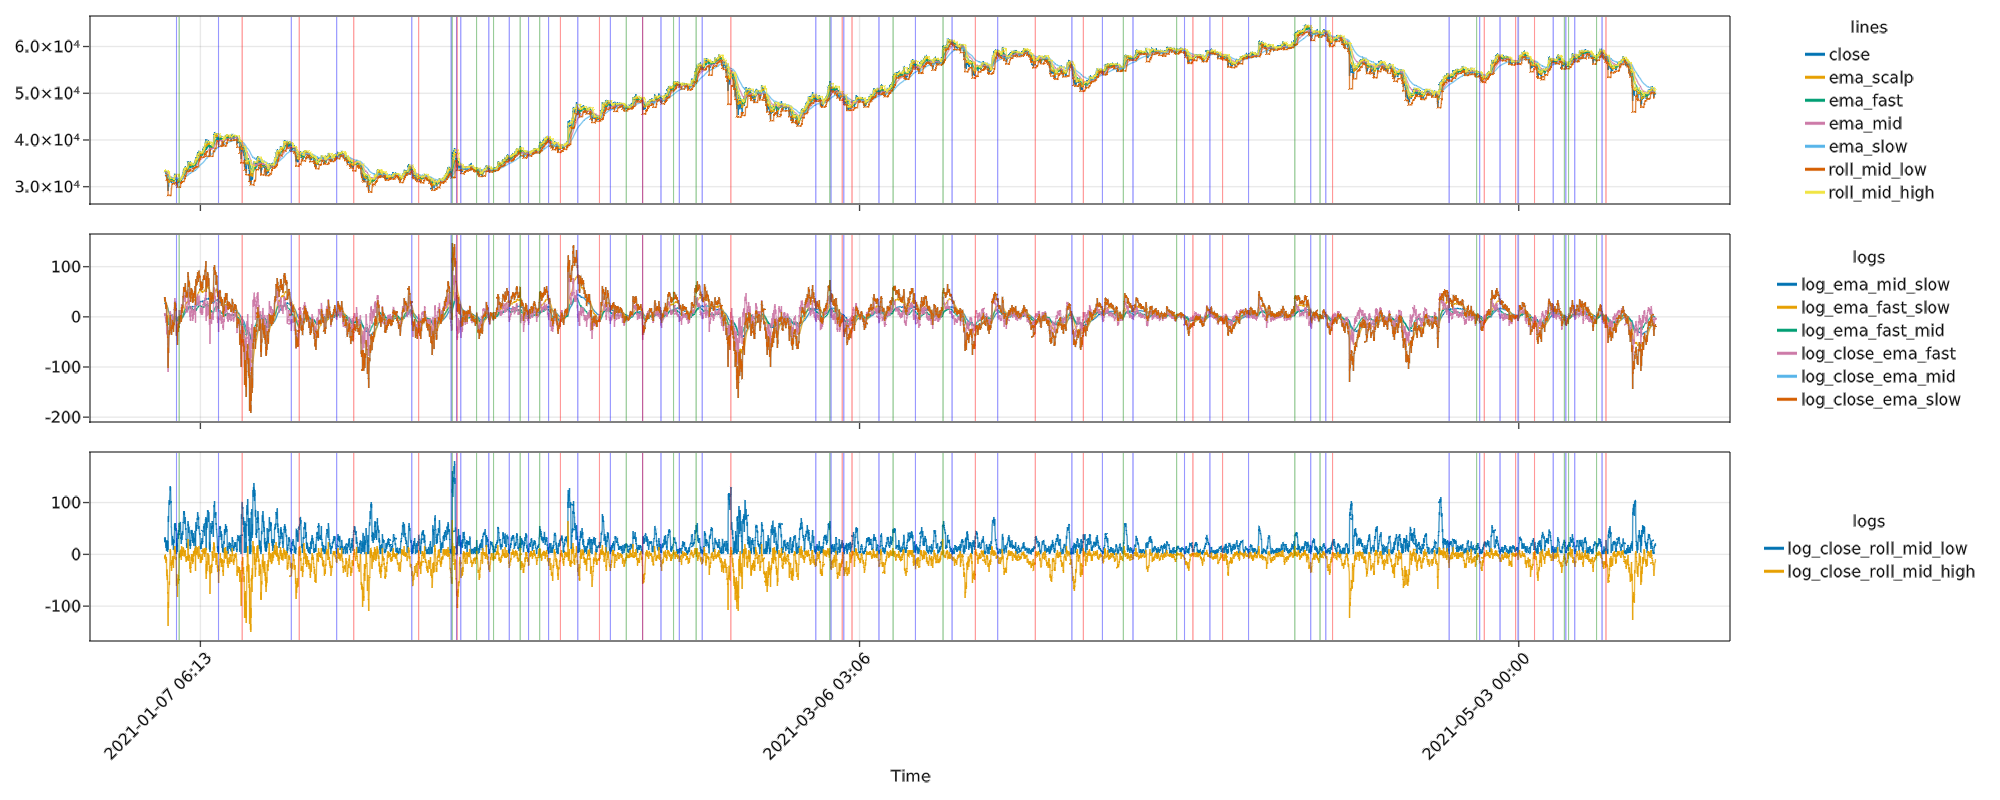

In [768]:
fig = Figure(resolution = (2000, 800))
ax1 = Axis(fig[1, 1])
ax2 = Axis(fig[2,1])
ax3 = Axis(fig[3,1], xticklabelrotation = pi/4)

# , xticks = (1:6, df.time)

#######

# ax3 = Axis(fig[2)
# lines!(ax1, df.unix_time, df.close, label = "close")
# :roll_fast_low, :roll_fast_high, :low, :high, 
ax1_cols = [:close, :ema_scalp, :ema_fast, :ema_mid, :ema_slow,  :roll_mid_low, :roll_mid_high] 
ax1_lines = [lines!(ax1, df.unix_time, df[:,col], label = string(col), linewidth=1 ) for col in ax1_cols]
fig[1, 2] = Legend(fig, ax1, "lines", framevisible = false)
# Legend(fig[1, 2], top_lines, string.(top_cols) )

# rs_h = IntervalSlider(fig[1, 2], range = LinRange(0, 1, 1000),
#     startvalues = (0.2, 0.8))
#-------
# ax1_active_lines = [true for col in ax1_cols]
# ax1_toggles = [Toggle(fig, active = true) for active in ax1_active_lines]
# ax1_labels = [Label(fig, lift(x -> x ? "$l visible" : "$l invisible", t.active)) for (t, l) in zip(ax1_toggles, ax1_cols)]
# fig[1, 2] = grid!(hcat(ax1_toggles, ax1_labels), tellheight = false)
# [connect!(l.visible, t.active) for (l,t) in zip(ax1_lines,ax1_toggles)]

#######
x3sum = df.
ax2_lines = [lines!(ax2, df.unix_time, df[:,col], label = string(col), linewidth=1) for col in ax2_cols]
fig[2, 2] = Legend(fig, ax2, "logs", framevisible = false)

# Legend(fig[2, 2], ax2_lines, string.(ax2_cols) )

#------
#######
ax3_cols = [:log_close_roll_mid_low, :log_close_roll_mid_high]
ax3_lines = [lines!(ax3, df.unix_time, df[:,col], label = string(col), linewidth=1) for col in ax3_cols]
fig[3, 2] = Legend(fig, ax3, "logs", framevisible = false)

for ax in [ax1, ax2, ax3]
    vlines!(ax,long_buys.unix_time, color=:blue, linewidth = 0.5)
    vlines!(ax,long_loss.unix_time, color=:red, linewidth = 0.5)
    vlines!(ax,long_profit.unix_time, color=:green, linewidth = 0.5)
end
-
# ax2_active_lines = [true for col in ax2_cols]
# ax2_toggles = [Toggle(fig, active = true) for active in ax2_active_lines]
# ax2_labels = [Label(fig, lift(x -> x ? "$l visible" : "$l invisible", t.active)) for (t, l) in zip(ax2_toggles, ax2_cols)]
# fig[2, 2] = grid!(hcat(ax2_toggles, ax2_labels), tellheight = false)
# [connect!(l.visible, t.active) for (l,t) in zip(ax2_lines,ax2_toggles)]


#######
linkxaxes!(ax1, ax2, ax3)
ax1.xticklabelsvisible = false
ax2.xticklabelsvisible = false
ax3.xtickformat = xs -> [Dates.format(unix2datetime(x),"YYYY-mm-dd HH:MM") for x in xs] 
ax3.xlabel = "Time"
# ax2.xtickrotation = 90

save("klines.png", fig, pt_per_unit = 0.75, px_per_unit = 1.0)

fig

In [230]:


Dates.format(now(),"YYYY-mm-dd")

"2021-05-23"